In [4]:
from astropy.modeling import models, fitting
import scipy.optimize
import numpy as np
from astropy.io import fits
from astropy import stats
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib as mpl
%matplotlib inline
from astropy.visualization import hist
from tempfile import mkdtemp
from pathlib import Path
from ccdproc import ImageFileCollection, Combiner, combine
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import glob
import sys
from astropy.stats import sigma_clip

path_dir = '/Users/mcgowkb1/ASTR8060/astr_8060_f23/software/ccd-reduction-and-photometry-guide/ccd-reduction-and-photometry-guide/notebooks/'
# Data Directory for Images folder

data_dir = '/Users/mcgowkb1/ASTR8060/Imaging/' #raw data 
reduced_dir = '/Users/mcgowkb1/ASTR8060/astr_8060_f23/reduced_data/10102023/' #processed data
sys.path.insert(0,path_dir)
from convenience_functions import show_image

CCDs are ideal because over the available dynamic range, they are very linear (that is,
one photon produces on electron).Test the linearity of the CCD using the sequence of
exposures labeled linearity test in the log. Make a plot of ADU versus time and determine
whether the chip is linear to the full 16 bits of the A-D converter. What you care about
here is whether the signal stays linear with exposure time as the flux in the peak pixel
approaches the 216 ADU limit.
**Linearity Test**

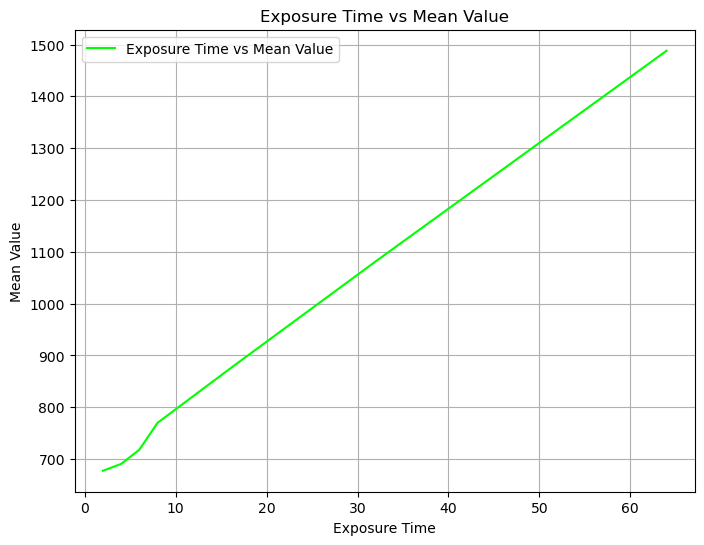

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

linear_test = []
exp_time = [2, 4, 6, 8, 16, 32, 64, 128]
test_id = ['a' + str(num).zfill(3) + '.fits' for num in np.arange(74, 81)]

for i, ids in enumerate(test_id):
    hdu = fits.open(data_dir + ids)
    img = hdu[0].data
    time = exp_time[i % len(exp_time)]
    linear_test.append((time, np.mean(img)))

# Plot ADU versus time
data = np.array(linear_test)
x = data[:, 0]  # Exposure time
y = data[:, 1]  # Mean value

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='lime', label='Exposure Time vs Mean Value')
plt.xlabel('Exposure Time')
plt.ylabel('Mean Value')
plt.title('Exposure Time vs Mean Value')
plt.legend()
plt.grid(True)
plt.show()


Use photutils to perform aperture photometry on three (non saturated) stars in the
PG1633+099 standard field: a really faint one, a medium bright one, and a bright one.
Perform aperture photometry using at least 5 aperture sizes from very small to very large
and make a plot that reproduces the one from Howell Figure 5.7 showing S/N as a function
of aperture radius. What is a good aperture size to use for this dataset?

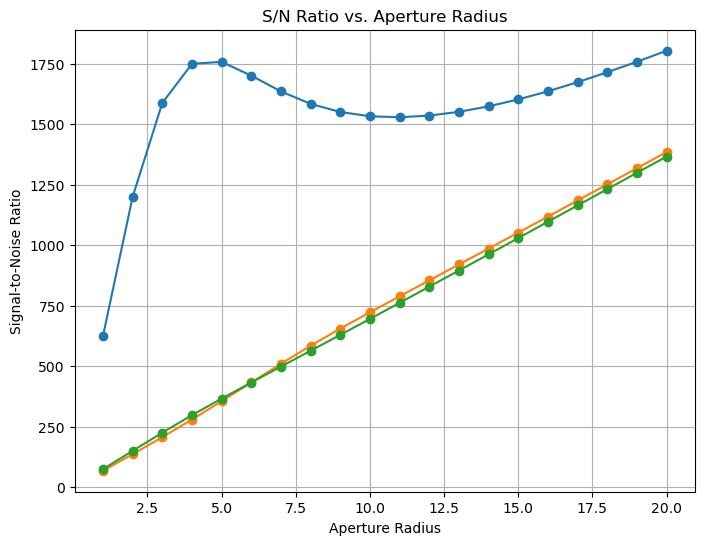

In [9]:
# Photometry analysis with different aperture radii
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.stats import sigma_clipped_stats

# Define positions of sources
positions = [(725.35, 1298.2), (934.519, 1225.63), (1028.43, 1413.46)]

# Define a range of aperture radii
radii = np.linspace(1, 20, 20)

# Calculate signal-to-noise ratio for different aperture sizes
sn_ratio = []
for r in radii:
    aperture = CircularAperture(positions, r=r)
    annulus_aperture = CircularAnnulus(positions, r_in=r + 5, r_out=r + 10)

    # Perform aperture photometry to measure signal and background noise
    phot_table = aperture_photometry(img, aperture)
    annulus_table = aperture_photometry(img, annulus_aperture)

    # Calculate total signal and background noise within the apertures
    signal = phot_table['aperture_sum']
    aperture_area = aperture.area_overlap(img)
    annulus_area = annulus_aperture.area_overlap(img)
    bkg_mean = annulus_table['aperture_sum'] / annulus_area
    noise = np.sqrt(bkg_mean * aperture_area)

    # Calculate signal-to-noise ratio and append to list
    sn_ratio.append(signal / noise)

# Plotting S/N vs. Aperture Radius
plt.figure(figsize=(8, 6))
plt.plot(radii, sn_ratio, marker='o', linestyle='-')
plt.xlabel('Aperture Radius')
plt.ylabel('Signal-to-Noise Ratio')
plt.title('S/N Ratio vs. Aperture Radius')
plt.grid(True)
plt.show()


Here are some considerations to help choose an appropriate aperture size:

- Source Size: If your sources are point-like and well-resolved, smaller apertures might be more appropriate to capture most of the source flux without much contamination from neighboring sources or background.
- Background Level: Larger apertures might be suitable if the background noise is low and you want to capture more flux from the sources. However, larger apertures might also include more background noise.
- Signal-to-Noise Ratio (S/N): A balance between capturing enough signal and minimizing noise is crucial. Aim for an aperture size that maximizes the S/N ratio.
- Aperture Contamination: Ensure that the aperture size does not encompass nearby sources or structures that could introduce contamination in your measurements.
- Photometric Precision: Smaller apertures might provide better precision for point sources, but larger apertures might be needed for extended sources.
- Experimentation: It's often useful to experiment with different aperture sizes and assess the resulting photometry to determine the optimal size for your specific dataset.


Considering the above, it is clear that smaller apertures wil lower our SNR. An aperature radius between 3 and 7.5 should suffice. So lets say 6. An SNR > 150 and 200 should be appropriate. 

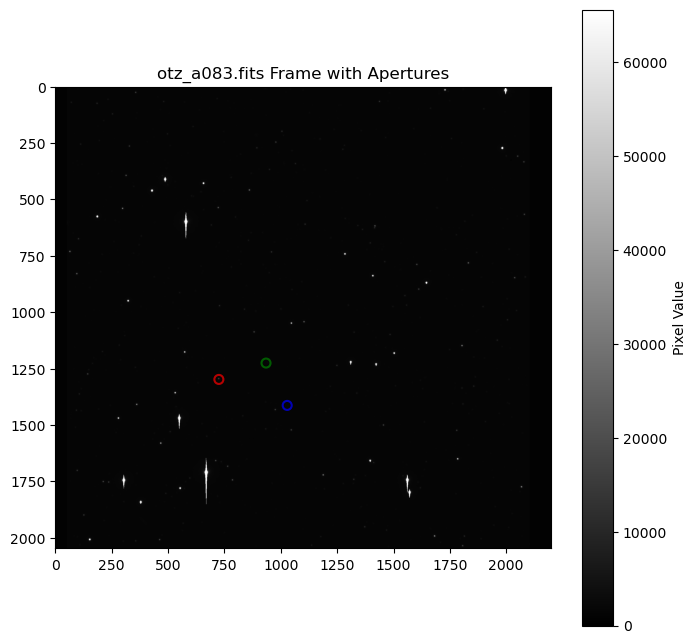

In [10]:
# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title('otz_a083.fits Frame with Apertures')

# Overlay apertures in different colors
colors = ['r', 'g', 'b', 'c', 'm', 'y','p','v','rb']
for i, ap in enumerate(aperture):
    ap.plot(color=colors[i], lw=1.5, alpha=0.7)

# Show the image with apertures
plt.colorbar(label='Pixel Value')
plt.show()

Identify the standard stars in the PG1633+099 frame from Landolt (1992).

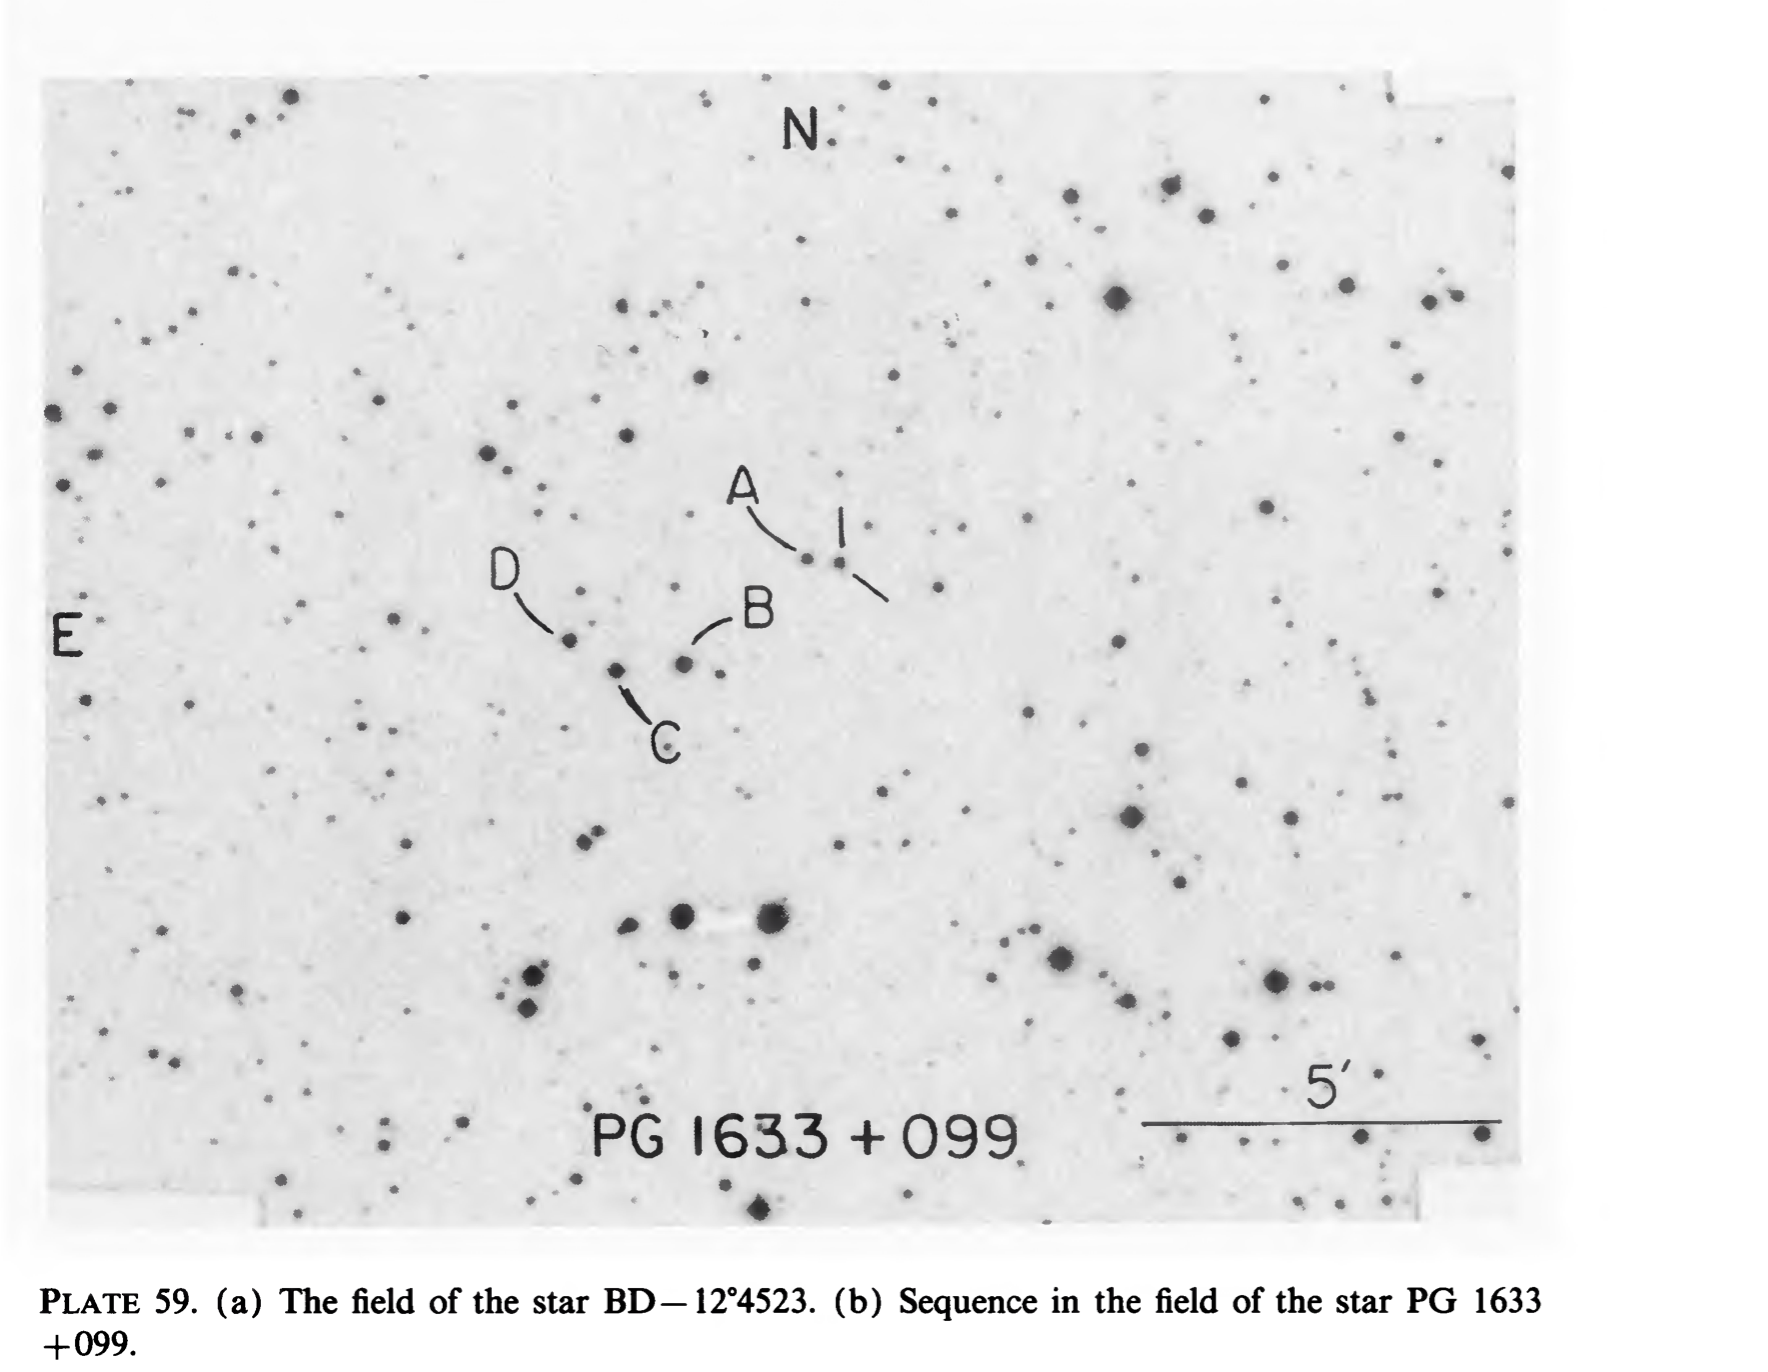

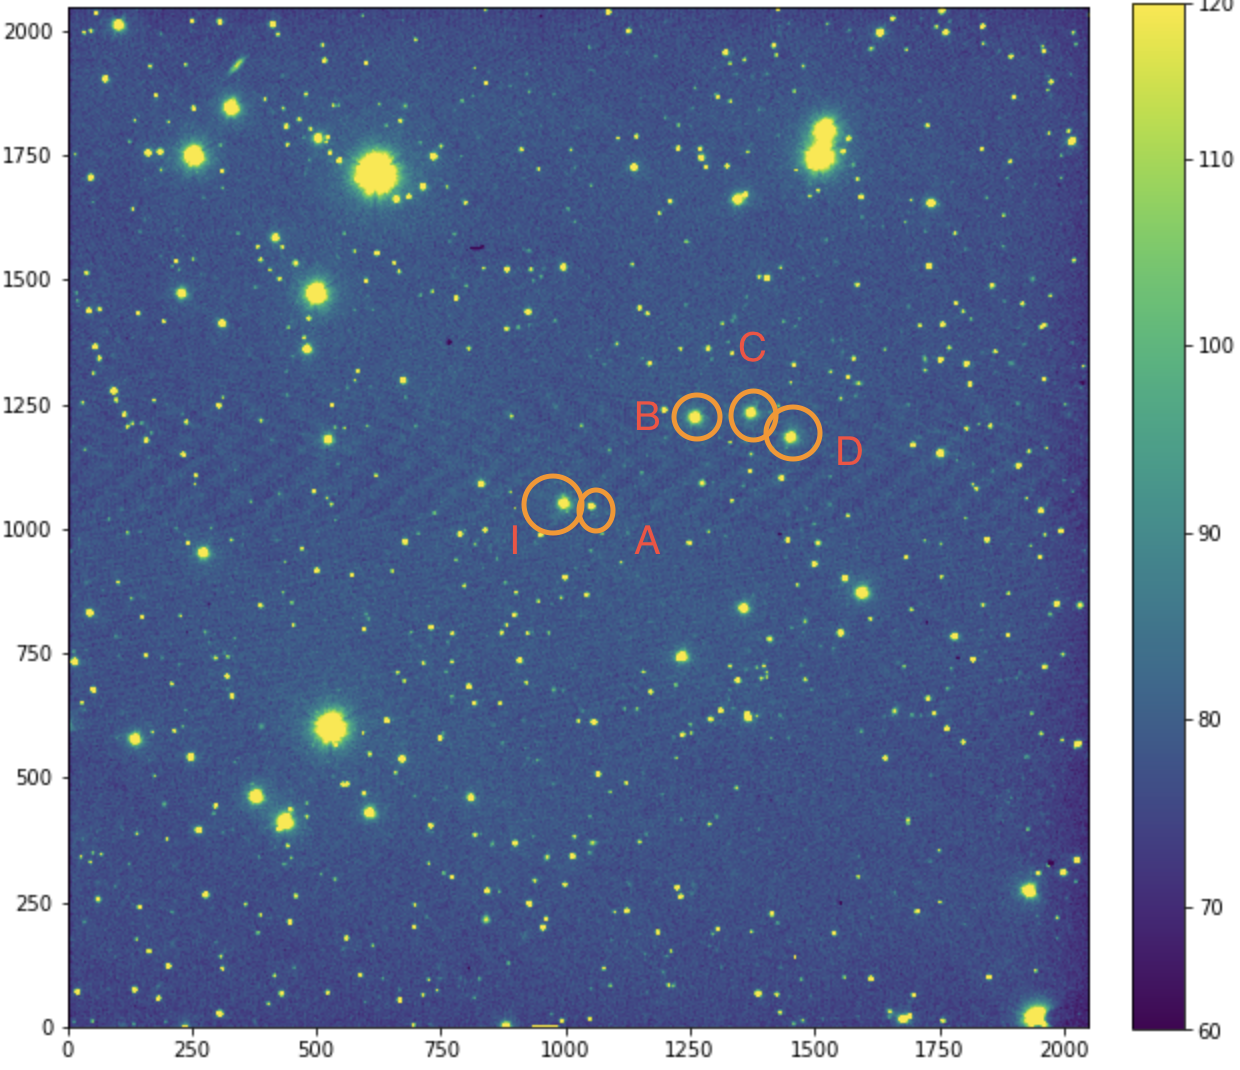

In [11]:
from PIL import Image
from IPython.display import display
img = Image.open('sample.png')
img2 = Image.open('sample2.png')
display(img)
display(img2)

(79.23177987857721, 78.99665019443592, 10.59319877802265)
 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1     19.76     37.78      0.51       0.04 ... 0.00   263.85   3.09 -1.23
  2    170.18     38.47      0.34      -0.19 ... 0.00   162.92   2.15 -0.83
  3    118.46     40.51      0.47       0.18 ... 0.00   321.84   3.95 -1.49
  4    128.88     55.45      0.43      -0.28 ... 0.00   136.84   1.63 -0.53
  5    144.54     75.60      0.40       0.24 ... 0.00   559.24   7.53 -2.19
  6    192.04    102.67      0.61      -0.07 ... 0.00   160.01   2.02 -0.76
  7    238.01    110.58      0.50       0.49 ... 0.00    87.87   1.22 -0.22
...       ...       ...       ...        ... ...  ...      ...    ...   ...
 21    298.72    293.12      0.47      -0.09 ... 0.00  5284.93  67.31 -4.57
 22    242.80    299.11      0.49      -0.08 ... 0.00 29185.01 369.21 -6.42
 23     77.80    338.12      0

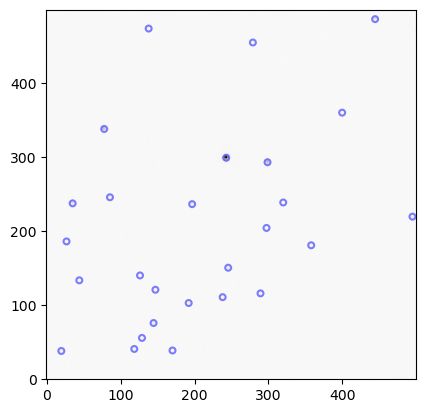

In [13]:
# Using imexam and starfinder 
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image

hdu = fits.open(reduced_dir + 'otz_a083.fits')
data = hdu[0].data[750:1250,750:1250]  # Access data from the primary HDU (hdu[0])
#data = hdu[0].data
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))  

from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76) 

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)


Extract instrumental magnitudes for all of your standard stars using an approach that
you’ve advocated for as best you can in the questions above.

-Write a function to do aperture photometry

Write a function that takes a filename and:

- Reads in the data.
- Finds all the sources in the image.
- Puts a circular aperture and background annulus on each of the stars.
- Calculates background-subtracted instrumental magnitudes.
- Plots the image and apertures for visual inspection.
- Returns a table of photometry, including the instrumental magnitudes.

In [12]:
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils import DAOStarFinder, CircularAperture, CircularAnnulus, aperture_photometry

def aperture_photometry_function(filename):
    # Read in the data
    hdu = fits.open(filename)
    img = hdu[0].data

    # Find sources in the image
    daofind = DAOStarFinder(threshold=5.0, fwhm=5.0)
    sources = daofind(img)

    # Extract x and y positions of detected sources
    positions = list(zip(sources['xcentroid'], sources['ycentroid']))

    # Define aperture and annulus sizes
    aperture_radius = 5.0
    annulus_in_radius = aperture_radius + 5.0
    annulus_out_radius = aperture_radius + 10.0

    # Create CircularAperture and CircularAnnulus objects for each source
    apertures = [CircularAperture(pos, r=aperture_radius) for pos in positions]
    annulus_apertures = [CircularAnnulus(pos, r_in=annulus_in_radius, r_out=annulus_out_radius) for pos in positions]

    # Perform aperture photometry
    phot_table = aperture_photometry(img, apertures, method='exact')
    bkg_table = aperture_photometry(img, annulus_apertures, method='exact')

    # Calculate background-subtracted instrumental magnitudes
    bkg_mean = bkg_table['aperture_sum'] / annulus_apertures[0].to_mask().area()
    instrumental_magnitudes = -2.5 * np.log10(phot_table['aperture_sum'] - bkg_mean)

    # Plot the image and apertures for visual inspection
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    for aperture in apertures:
        aperture.plot(color='red', lw=1.5, alpha=0.7)
    plt.title('Image with Apertures')
    plt.colorbar(label='Pixel Value')
    plt.show()

    # Add instrumental magnitudes to the photometry table and return
    phot_table['instrumental_magnitude'] = instrumental_magnitudes
    return phot_table

/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_70790/573156149.py:3: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, CircularAnnulus, aperture_photometry
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_70790/573156149.py:3: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, CircularAnnulus, aperture_photometry
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_70790/573156149.py:3: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.apert

In [ ]:
# list of standard stars via starfinder 

In [54]:
hdu = fits.open(data_dir + 'a080.fits')
img = hdu[0].data
hdr = hdu[0].header
hdr

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2200 / Axis length                                    
NAXIS2  =                 2048 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2009-09-15T15:56:29' / Date FITS file was generated                  
IRAF-TLM= '09:56:28 (15/09/2009)' / Time of last modification                   
DATAMIN =           0.000000E0 / Minimum data value                             
DATAMAX =           6.553500

In [13]:
np.dtype(np.mean(img))

dtype('float64')

Use photutils to perform aperture photometry on three (non saturated) stars in the
PG1633+099 standard field: a really faint one, a medium bright one, and a bright one.
Perform aperture photometry using at least 5 aperture sizes from very small to very large
and make a plot that reproduces the one from Howell Figure 5.7 showing S/N as a function
of aperture radius. What is a good aperture size to use for this dataset?

In [74]:
x1 = 725.35 #bright 
x2 = 934.519 #med bright
x3 = 1028.43 #dim 
y1 = 1298.2
y2 = 1225.63
y3 = 1413.46

positions = [(x1,y1),(x2,y2),(x3,y3)]
#aperture = CircularAperture(positions, r=4.0)

In [82]:
radii = [1.0,2.0,5.0,10.0, 15.0, 20.0]
apertures = [CircularAperture(positions, r=r) for r in radii]
phot_table = aperture_photometry(img, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
phot_table

<QTable length=3>
  id  xcenter ycenter ... aperture_sum_3 aperture_sum_4 aperture_sum_5
        pix     pix   ...                                             
int64 float64 float64 ...    float64        float64        float64    
----- ------- ------- ... -------------- -------------- --------------
    1  725.35  1298.2 ...      24852.292      55913.279      99273.803
    2 934.519 1225.63 ...      24319.144       54522.56      97302.911
    3 1028.43 1413.46 ...      24437.039      54947.938      97708.034

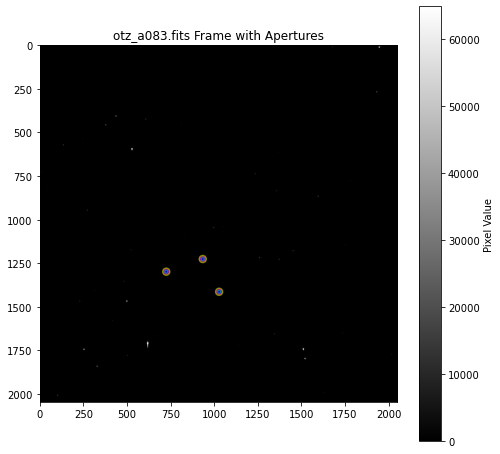

In [86]:
# Define positions and radii
x1, x2, x3 = 725.35, 934.519, 1028.43
y1, y2, y3 = 1298.2, 1225.63, 1413.46
positions = [(x1, y1), (x2, y2), (x3, y3)]
radii = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0]

# Create CircularAperture objects
#aperture = CircularAperture(positions, r=4.0)
apertures = [CircularAperture(positions, r=r) for r in radii]

# Perform aperture photometry
phot_table = aperture_photometry(img, apertures)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title('otz_a083.fits Frame with Apertures')

# Overlay apertures in different colors
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, ap in enumerate(apertures):
    ap.plot(color=colors[i], lw=1.5, alpha=0.7)

# Show the image with apertures
plt.colorbar(label='Pixel Value')
plt.show()


In [102]:
from photutils.aperture import CircularAnnulus, CircularAperture,ApertureStats

aperture = CircularAperture(positions, r=4.0)
annulus_aperture = CircularAnnulus(positions, r_in=10.0, r_out=15.0)

aperstats = ApertureStats(img, annulus_aperture)
bkg_mean = aperstats.mean
print(bkg_mean)  

[79.0871834  76.80082407 77.69236403]


In [103]:
from photutils.aperture import aperture_photometry
phot_table = aperture_photometry(img, aperture)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1  725.35  1298.2    3918.6877
  2 934.519 1225.63     3832.473
  3 1028.43 1413.46    3875.1304


In [104]:
aperture_area = aperture.area_overlap(img)
print(aperture_area)

[50.2654824574367, 50.2654824574367, 50.26548245743669]


In [108]:
total_bkg = bkg_mean * aperture_area
print(total_bkg)
phot_bkgsub = phot_table['aperture_sum'] - total_bkg
print(bkg_mean)

[3975.35542971 3860.43047514 3905.24416128]
[79.0871834  76.80082407 77.69236403]


In [107]:
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum total_bkg aperture_sum_bkgsub
      pix     pix                                             
--- ------- ------- ------------ --------- -------------------
  1  725.35  1298.2    3918.6877 3975.3554           -56.66773
  2 934.519 1225.63     3832.473 3860.4305          -27.957517
  3 1028.43 1413.46    3875.1304 3905.2442           -30.11379


In [ ]:
A = aperture_area
T = aperture_sum 
B = bkg_mean

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


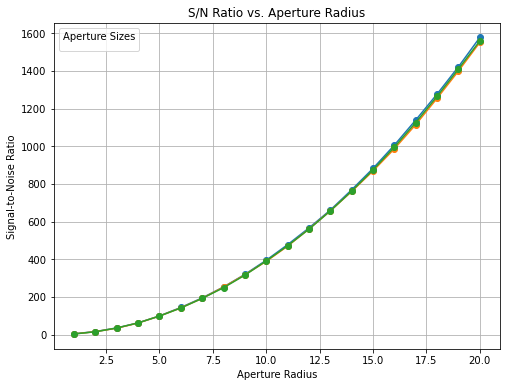

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.stats import sigma_clipped_stats


# Define positions of sources
x1, x2, x3 = 725.35, 934.519, 1028.43
y1, y2, y3 = 1298.2, 1225.63, 1413.46
positions = [(x1, y1), (x2, y2), (x3, y3)]

# Define a range of aperture radii
radii = np.linspace(1, 20, 20)  # Adjust as needed

# Calculate the signal and noise for each aperture size
sn_ratio = []
for r in radii:
    aperture = CircularAperture(positions, r=r)
    annulus_aperture = CircularAnnulus(positions, r_in=r+5, r_out=r+10)  # Define annulus aperture

    # Perform aperture photometry to measure signal and background noise
    phot_table = aperture_photometry(img, aperture)
    annulus_table = aperture_photometry(img, annulus_aperture)

    # Calculate total signal and background noise within the apertures
    signal = phot_table['aperture_sum']
    annulus_area = annulus_aperture.area_overlap(img)  # Get the annulus area separately
    bkg_mean = annulus_table['aperture_sum'] / annulus_area
    noise = np.sqrt(bkg_mean * aperture_area)

    # Calculate signal-to-noise ratio and append to list
    sn_ratio.append(signal / noise)

# Plotting S/N vs. Aperture Radius
plt.figure(figsize=(8, 6))
plt.plot(radii, sn_ratio, marker='o', linestyle='-')
plt.xlabel('Aperture Radius')
plt.ylabel('Signal-to-Noise Ratio')
plt.title('S/N Ratio vs. Aperture Radius')
plt.grid(True)
#plt.legend(title='Aperture Sizes', loc = 'best')
plt.show()


Here are some considerations to help choose an appropriate aperture size:

- Source Size: If your sources are point-like and well-resolved, smaller apertures might be more appropriate to capture most of the source flux without much contamination from neighboring sources or background.
- Background Level: Larger apertures might be suitable if the background noise is low and you want to capture more flux from the sources. However, larger apertures might also include more background noise.
- Signal-to-Noise Ratio (S/N): A balance between capturing enough signal and minimizing noise is crucial. Aim for an aperture size that maximizes the S/N ratio.
- Aperture Contamination: Ensure that the aperture size does not encompass nearby sources or structures that could introduce contamination in your measurements.
- Photometric Precision: Smaller apertures might provide better precision for point sources, but larger apertures might be needed for extended sources.
- Experimentation: It's often useful to experiment with different aperture sizes and assess the resulting photometry to determine the optimal size for your specific dataset.


Considering the above, it is clear that smaller apertures wil lower our SNR. An aperature radius between 3 and 7.5 should suffice. So lets say 6. An SNR between 150 and 200 should be appropriate. 

Identify the standard stars in the PG1633+099 frame from Landolt (1992).

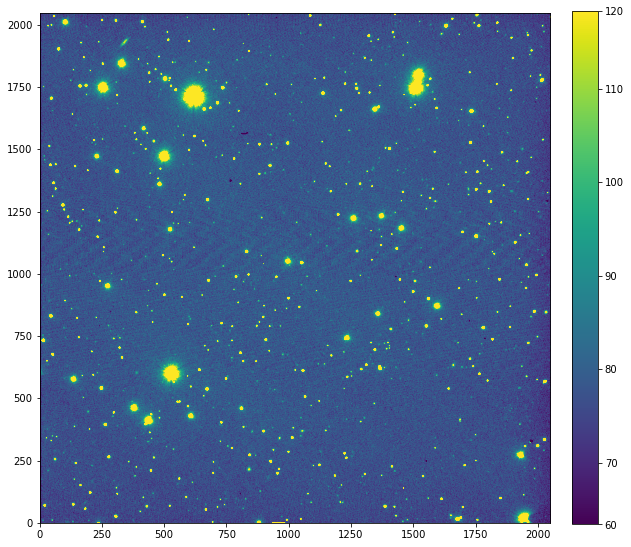

In [3]:
# Using the filter table and standard images I have identified the standard stars
hdu = fits.open(reduced_dir + 'otz_a083.fits')
img = hdu[0].data
show_image(img)


(79.23177987857721, 78.99665019443592, 10.59319877802265)
 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1     19.76     37.78      0.51       0.04 ... 0.00   263.85   3.09 -1.23
  2    170.18     38.47      0.34      -0.19 ... 0.00   162.92   2.15 -0.83
  3    118.46     40.51      0.47       0.18 ... 0.00   321.84   3.95 -1.49
  4    128.88     55.45      0.43      -0.28 ... 0.00   136.84   1.63 -0.53
  5    144.54     75.60      0.40       0.24 ... 0.00   559.24   7.53 -2.19
  6    192.04    102.67      0.61      -0.07 ... 0.00   160.01   2.02 -0.76
  7    238.01    110.58      0.50       0.49 ... 0.00    87.87   1.22 -0.22
...       ...       ...       ...        ... ...  ...      ...    ...   ...
 21    298.72    293.12      0.47      -0.09 ... 0.00  5284.93  67.31 -4.57
 22    242.80    299.11      0.49      -0.08 ... 0.00 29185.01 369.21 -6.42
 23     77.80    338.12      0

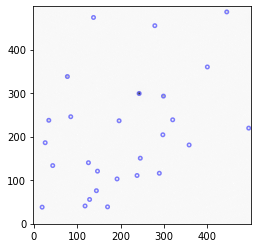

In [21]:
# Using imexam and starfinder 
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image

hdu = fits.open(reduced_dir + 'otz_a083.fits')
data = hdu[0].data[750:1250,750:1250]  # Access data from the primary HDU (hdu[0])
#data = hdu[0].data
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))  

from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76) 

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

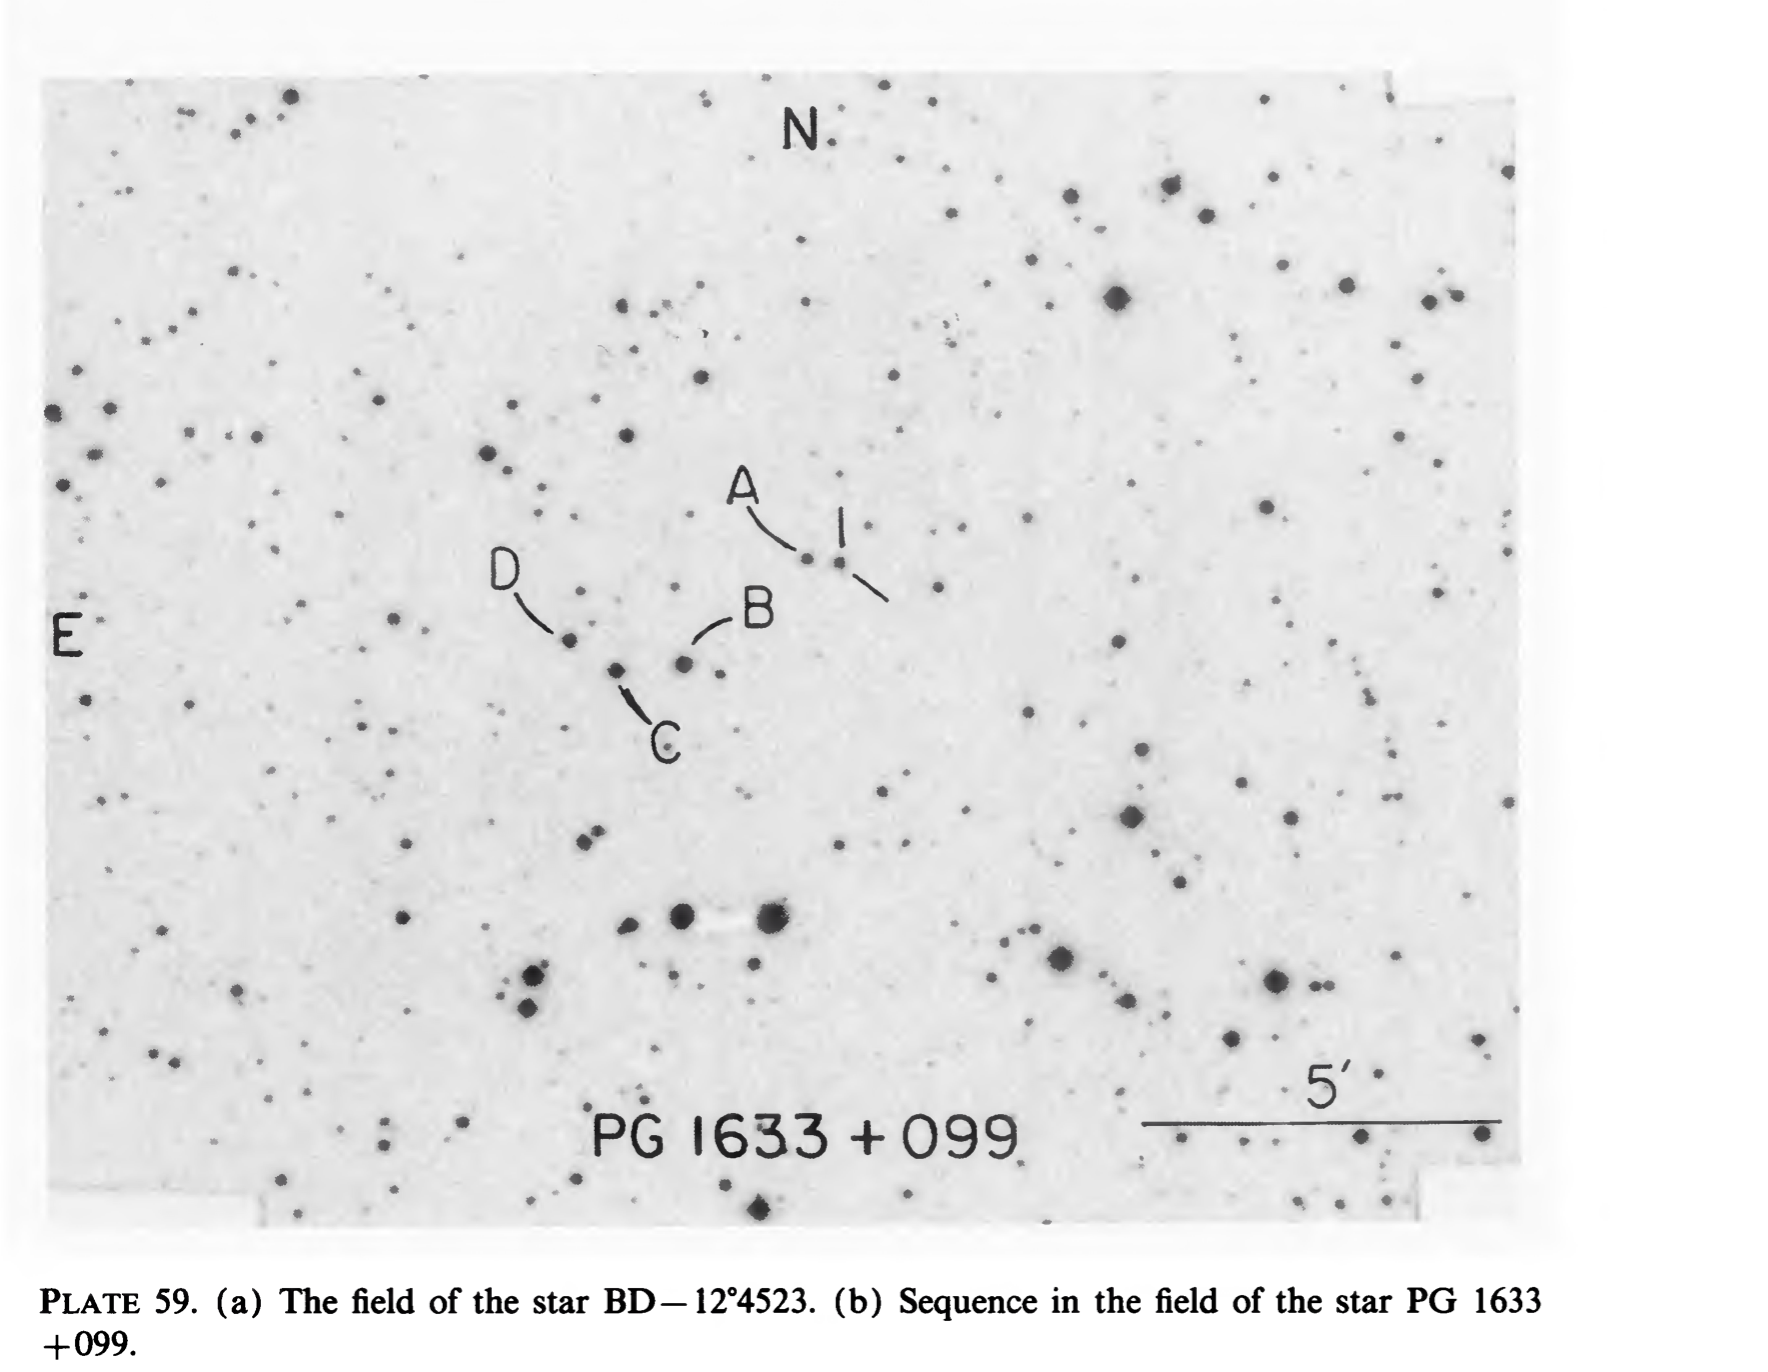

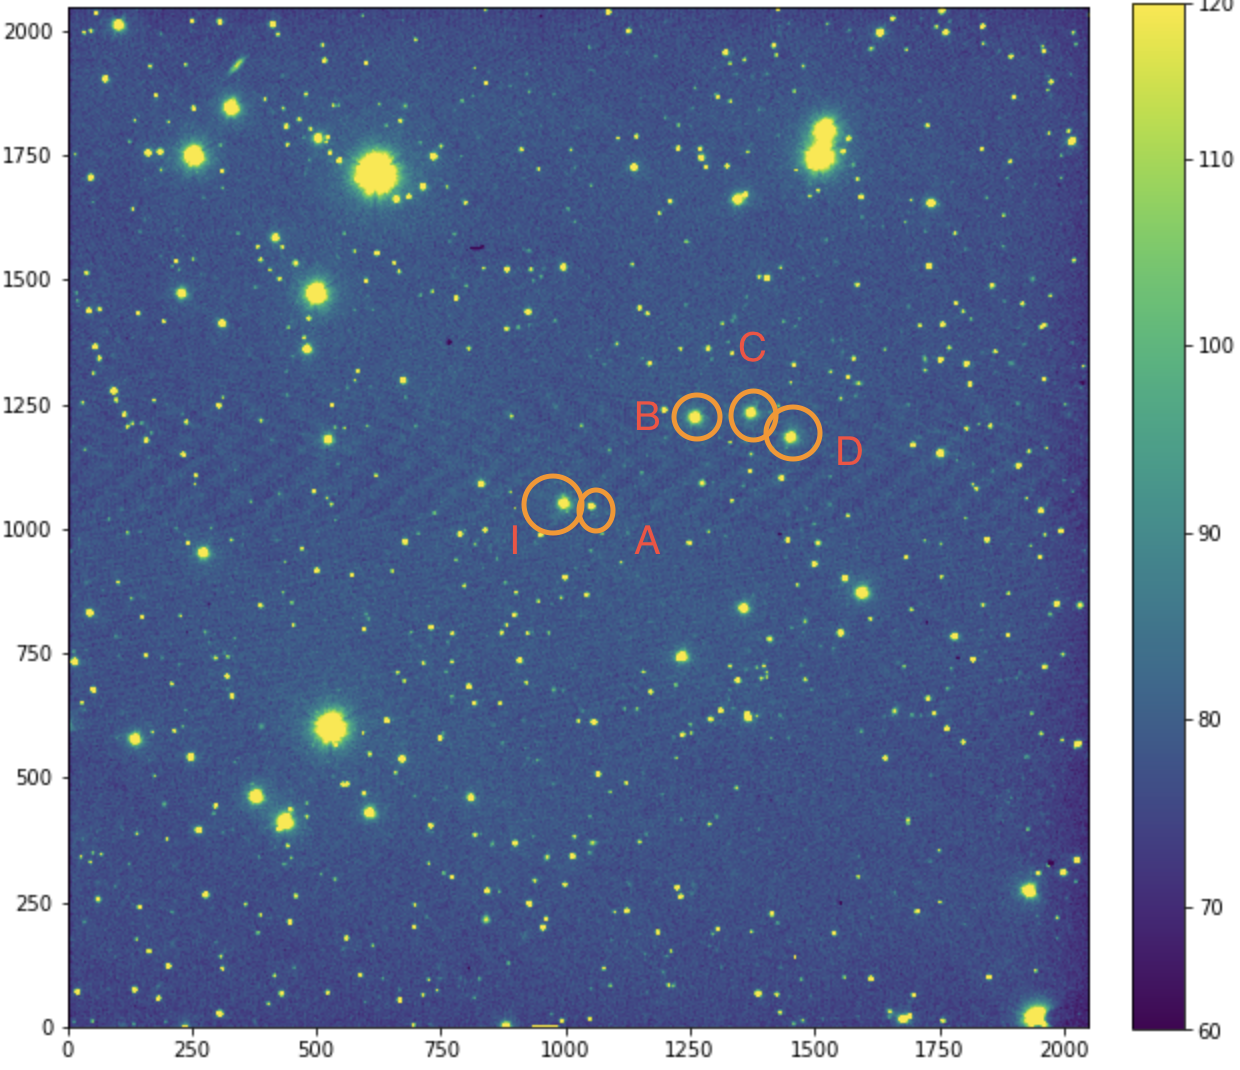

In [22]:
from PIL import Image
from IPython.display import display
img = Image.open('sample.png')
img2 = Image.open('sample2.png')
display(img)
display(img2)

Extract instrumental magnitudes for all of your standard stars using an approach that
you’ve advocated for as best you can in the questions above.

-Write a function to do aperture photometry

Write a function that takes a filename and:

-Reads in the data.
-Finds all the sources in the image.
-Puts a circular aperture and background annulus on each of the stars.
-Calculates background-subtracted instrumental magnitudes.
-Plots the image and apertures for visual inspection.
-Returns a table of photometry, including the instrumental magnitudes.


In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils import DAOStarFinder, CircularAperture, CircularAnnulus, aperture_photometry

def aperture_photometry_function(filename):
    # Read in the data
    hdu = fits.open(filename)
    img = hdu[0].data

    # Find sources in the image
    daofind = DAOStarFinder(threshold=5.0, fwhm=5.0)
    sources = daofind(img)

    # Extract x and y positions of detected sources
    positions = list(zip(sources['xcentroid'], sources['ycentroid']))

    # Define aperture and annulus sizes
    aperture_radius = 5.0
    annulus_in_radius = aperture_radius + 5.0
    annulus_out_radius = aperture_radius + 10.0

    # Create CircularAperture and CircularAnnulus objects for each source
    apertures = [CircularAperture(pos, r=aperture_radius) for pos in positions]
    annulus_apertures = [CircularAnnulus(pos, r_in=annulus_in_radius, r_out=annulus_out_radius) for pos in positions]

    # Perform aperture photometry
    phot_table = aperture_photometry(img, apertures, method='exact')
    bkg_table = aperture_photometry(img, annulus_apertures, method='exact')

    # Calculate background-subtracted instrumental magnitudes
    bkg_mean = bkg_table['aperture_sum'] / annulus_apertures[0].to_mask().area()
    instrumental_magnitudes = -2.5 * np.log10(phot_table['aperture_sum'] - bkg_mean)

    # Plot the image and apertures for visual inspection
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    for aperture in apertures:
        aperture.plot(color='red', lw=1.5, alpha=0.7)
    plt.title('Image with Apertures')
    plt.colorbar(label='Pixel Value')
    plt.show()

    # Add instrumental magnitudes to the photometry table and return
    phot_table['instrumental_magnitude'] = instrumental_magnitudes
    return phot_table


Plot your standard star instrumental magnitudes versus their airmass (or since you have
many different standard stars taken at different airmass, plot the difference between the
accepted magnitude and your instrumental magnitude versus airmass). Use one of the
linear fitting routines in Python to do a least squares fit to find and plot the extinction
coefficients at each filter. You can find their magnitudes and colors in Landolt (1992).

In [ ]:
# Extract instrumental magnitudes and airmass values
instrumental_magnitudes = standard_star_data['instrumental_magnitude']
airmass_values = standard_star_data['airmass']

# Plot instrumental magnitudes vs airmass
plt.figure(figsize=(8, 6))
plt.scatter(airmass_values, instrumental_magnitudes, color='blue', alpha=0.7)
plt.xlabel('Airmass')
plt.ylabel('Instrumental Magnitude')
plt.title('Instrumental Magnitudes vs Airmass')
plt.grid(True)
plt.show()


In [ ]:
from scipy.optimize import curve_fit

# Define the linear function for fitting
def linear_function(airmass, a, b):
    return a * airmass + b

# Perform the least squares fit
popt_U, _ = curve_fit(linear_function, airmass_values, magnitudes_U)

# Plot the data and fitted line
plt.figure(figsize=(8, 6))
plt.scatter(airmass_values, magnitudes_U, color='blue', label='U Filter')
plt.plot(airmass_values, linear_function(airmass_values, *popt_U), color='red', label='Fit Line')
plt.xlabel('Airmass')
plt.ylabel('Magnitudes in U Filter')
plt.title('Extinction Coefficients - U Filter')
plt.legend()
plt.grid(True)
plt.show()


After extinction correcting your standard stars to zero airmasses (i.e., you’re correcting
to the top of the atmosphere), make a plot of the difference between real magnitudes and
instrumental magnitudes using your standard stars as a function of V􀀀R color and B􀀀V
color. Fit a linear relation to this trend. The fit gives you your instrumental zero points
and the first order color term which let you transform your instrumental photometry to
the standard system. Tabulate the instrumental zero point and first order color terms for
each band in a neat, digestible way.

In [ ]:
from scipy.optimize import curve_fit

# Calculate differences
differences_VR = real_magnitudes - corrected_magnitudes
# Assuming V-R and B-V colors are already available

# Define the linear function for fitting
def linear_function(colors, a, b):
    return a * colors + b

# Perform the least squares fit for V-R color
popt_VR, _ = curve_fit(linear_function, VR_colors, differences_VR)

# Plotting differences vs V-R color with fitted line
plt.figure(figsize=(8, 6))
plt.scatter(VR_colors, differences_VR, color='blue', label='V-R Color')
plt.plot(VR_colors, linear_function(VR_colors, *popt_VR), color='red', label='Fit Line')
plt.xlabel('V-R Color')
plt.ylabel('Difference (Real Mag - Instrumental Mag)')
plt.title('Difference vs V-R Color')
plt.legend()
plt.grid(True)
plt.show()


Using the extinction terms and color terms derived for the imaging dataset previously, do
photometry on the stars in NGC6823 and make a color magnitude diagram of this open
cluster. Either V vs. B-V or R vs. R-Iare the most common ones you might find, but
there may be others in the literature and you are welcome to follow their lead.